# Deep learning digit-recognizer

In this notebook, we are going to create an algorithm which will predict the digit on a photo. This algorithm well learn from train dataset and then it will predict the digit displayed in each image of the test dataset. 

Usually, convolutional neural networks are good for image processing related tasks so we will use it as model.

## Imports and useful functions

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
#path of datasets
path_train = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'datasets/train.csv')
path_test = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'datasets/test.csv')

## Exploration of data

*Let's begin by printing a preview of the dataset and look at its size and what it contains:*

In [3]:
#create dataframe for training dataset and print 5 first rows as preview
train_df_raw = pd.read_csv(path_train)
print('Number of rows: {0} \nNumber of columns: {1}'.format(train_df_raw.shape[0], train_df_raw.shape[1]))
print('\nPreview of the dataset:\n')
train_df_raw.head()

Number of rows: 42000 
Number of columns: 785

Preview of the dataset:



,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# print infos about the dataset
train_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [5]:
train_df_raw.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [6]:
# Check if there are missing datas
train_df_raw.isnull().values.any()
train_df_raw.isna().values.any()

False

*From this first preview and according to information from kaggle, it seems that each image contains 784 pixels (28x28 pixels), each pixel contain a value between 0 and 254 reprensenting the gray level of this pixel. There is no missing values. Let's try to display the first 10 images from the values of the dataset:*

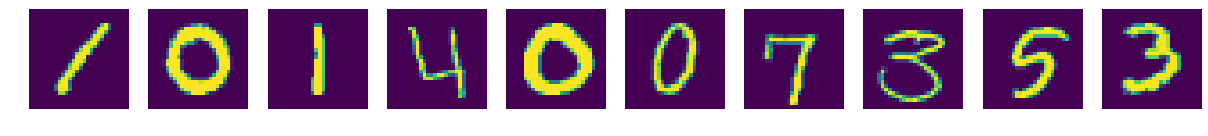

In [7]:
def dislay_images_from_pixels(nb): 
    images = [np.array(train_df_raw.drop(['label'], 1).iloc[i].tolist()).reshape(28, 28) for i in range (nb)]

    fig, plots = plt.subplots(1, nb)
    fig.set_size_inches(21, 10)
    for n in range(nb):
        plots[n].imshow(images[n])
        plots[n].axis('off')
        
dislay_images_from_pixels(10)

## Building the model

In [8]:
train_df = train_df_raw.copy()

# Let's divide the train dataset in two datasets to evaluate perfomance of machine learning models used
X_train = train_df.drop(['label'], 1)
Y_train = train_df['label']

# Format data to pass to keras CNN model
X_train = X_train.values.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
# Convert labels to categorical one-hot encoding
Y_train = np_utils.to_categorical(Y_train, 10)

In [10]:
def build_cnn():
    model = Sequential()

    model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(64,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    return model

## Prediction on test data

In [11]:
X_test = pd.read_csv(path_test)
X_test = X_test.values.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

In [ ]:
model = build_cnn()
model.fit(X_train, Y_train, batch_size=32, nb_epoch=10, verbose=1)
predict_result = model.predict_classes(X_test, verbose=0)

Epoch 1/10
42000/42000 [==============================] - 413s 10ms/step - loss: 0.2239 - acc: 0.9316
Epoch 2/10
42000/42000 [==============================] - 508s 12ms/step - loss: 0.0770 - acc: 0.9758
Epoch 3/10
42000/42000 [==============================] - 442s 11ms/step - loss: 0.0621 - acc: 0.9811
Epoch 4/10
42000/42000 [==============================] - 442s 11ms/step - loss: 0.0562 - acc: 0.9828
Epoch 5/10
42000/42000 [==============================] - 345s 8ms/step - loss: 0.0501 - acc: 0.9851
Epoch 6/10
42000/42000 [==============================] - 310s 7ms/step - loss: 0.0423 - acc: 0.9868
Epoch 7/10
42000/42000 [==============================] - 312s 7ms/step - loss: 0.0414 - acc: 0.9874
Epoch 8/10
23072/42000 [===============>..............] - ETA: 1:34:37 - loss: 0.0377 - acc: 0.9890

In [ ]:
# save model
model.save("cnn.h5")

# reload model
from keras.models import load_model
#model = load_model('cnn.h5')

## Submission

In [ ]:
prediction = model.predict_classes(X_test, verbose=0)
submission = pd.DataFrame({"ImageId": list(range(1,len(predict_result)+1)),
                         "Label": prediction})
submission.to_csv("submission.csv", index=False, header=True)